In [94]:
import pandas as pd
import numpy as np
from scipy import stats
from os.path import basename
from blab.array import loadmat
from glob import glob
import bct
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
import scipy.io as spio
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests

In [121]:
mbrt_df = pd.read_csv('mbrt_all.csv')
mbrt_df.set_index(['Day', 'Session', 'Subject'], inplace=True)
mbrt_im1 = mbrt_df.query('Subject != 10 and Session == "Im1"')['MBRT ANY'].to_list()
mbrt_im1 = np.array(mbrt_im1[15:] + mbrt_im1[:15])

mbrt_im2 = mbrt_df.query('Subject != 10 and Session == "Im2" and Day == "TMS"')['MBRT ANY'].to_list()[:14]
mbrt_im2 = np.array(mbrt_im2)

fnames_im1 = sorted(glob('../data/fnc/fnc_im1_nocorrection/*'))
fnames_im2 = sorted(glob('../data/fnc/fnc_im2/*'))

In [ ]:
def corr(src, trgt):
    res = []
    mask = ~np.isnan(trgt)
    src = src.copy()[..., mask]
    trgt = trgt.copy()[mask]
    for i in src.reshape(116*116, -1):
        if np.all(i == i[0]):
            res.append((np.nan, np.nan))
        else:
            temp = stats.permutation_test([i, trgt], lambda *o: stats.pearsonr(*o)[0], permutation_type='pairings', n_resamples=1000)
            res.append((temp.statistic, temp.pvalue))
    return np.array(res).reshape(116, 116, 2)

res_matr = {}
for fname in tqdm(fnames_im1):
    sas = loadmat(fname)
    sos = sas['nbs']
    cons = sos['conmatr']
    n = cons.shape[-1]//2
    cons = cons[..., :n] - cons[..., n:] # post - base
    corr_mat = corr(cons, mbrt_im1)
    res_matr[basename(fname)] = corr_mat
    datar = corr_mat[..., 0].copy()
    a = np.tril_indices(116)
    corr_mat[a] *= np.nan
    # corr_mat[..., 1] = multipletests(corr_mat[..., 1], alpha=0.05, method='hs', is_sorted=False, returnsorted=False)[-1]
    inds = np.arange(116)
    a, b = np.meshgrid(inds, inds)
    mask = (corr_mat[..., 1] < 0.05)
    row, col = a[mask], b[mask]
    datap = corr_mat[..., 1][mask]
    inds = np.argsort(datap)
    cut = len(inds)
    datap = datap[inds][:cut]
    row, col = row[inds][:cut], col[inds][:cut]

    # datar = csc_matrix((datar, (row, col)), shape=(116, 116))
    datap = csc_matrix((np.ones(cut), (row, col)), shape=(116, 116))
    sas['nbs']['NBS']['con_mat'] = datap
    sas['nbs']['NBS']['test_stat'] = datar
    spio.savemat(f'{fname}_UPD.mat', sas)

 20%|██        | 1/5 [22:56<1:31:44, 1376.08s/it]

In [175]:
inds = np.arange(116)
a, b = np.meshgrid(inds, inds)
mask = (corr_mat[..., 1] < 0.05)
inds = np.vstack([a[mask], b[mask]])
arr = np.hstack([inds.T, corr_mat[..., 0][mask][..., None], corr_mat[..., 1][mask][..., None]])
df = pd.DataFrame(arr, columns=['Node.A', 'Node.B', 'Corr. coef.', 'p-value'])
df.sort_values('p-value')

,Node.A,Node.B,Corr. coef.,p-value
38,56.0,13.0,-0.558739,0.000726
186,102.0,87.0,-0.517674,0.002032
107,102.0,39.0,-0.516568,0.002086
137,60.0,53.0,0.515664,0.002131
67,87.0,19.0,-0.514930,0.002167
...,...,...,...,...
86,74.0,33.0,-0.345784,0.048717
62,52.0,19.0,0.344991,0.049270
199,105.0,99.0,-0.344818,0.049392
12,113.0,3.0,0.344786,0.049415


/Users/nikitasmirnov/miniconda3/envs/NCT/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

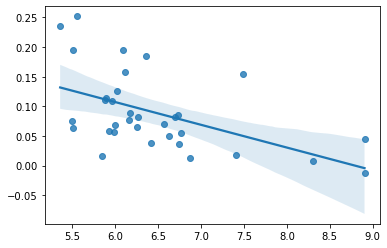

In [177]:
# plt.scatter(mbrt_all, sas)
sas = cons[102, 87]
sns.regplot(mbrt_all, sas)

(0.535279576158992, 6.195437496321344e-05)


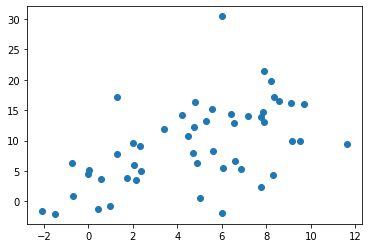

In [221]:
x = np.linspace(0, 10, 50)
y = x*2
x += np.random.normal(0, 2, size=50)
y += np.random.normal(0, 5, size=50)

plt.scatter(x, y)
print(stats.pearsonr(x, y))

In [230]:
perm_dist = [stats.pearsonr(x, np.random.permutation(y))[0] for i in range(10000)]

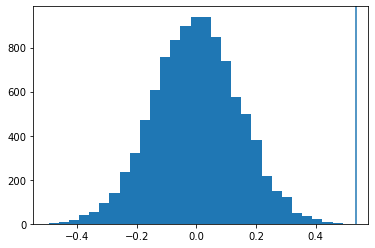

In [232]:
plt.hist(perm_dist, bins=30)
plt.axvline(stats.pearsonr(x, y)[0])

In [233]:
stats.pearsonr(x, y)

(0.535279576158992, 6.195437496321344e-05)

In [237]:
sas = stats.permutation_test([x, y], lambda *o: stats.pearsonr(*o)[0], permutation_type='pairings')

(array([  2.,   1.,   4.,   5.,   5.,  12.,  17.,  27.,  42.,  45.,  66.,
         95., 127., 138., 188., 231., 273., 309., 364., 404., 462., 490.,
        508., 544., 533., 547., 526., 553., 523., 467., 419., 367., 333.,
        287., 241., 200., 146., 139., 110.,  80.,  43.,  39.,  30.,  18.,
         14.,  15.,   3.,   4.,   2.,   1.]),
 array([-0.4988591 , -0.47895626, -0.45905343, -0.4391506 , -0.41924777,
        -0.39934493, -0.3794421 , -0.35953927, -0.33963643, -0.3197336 ,
        -0.29983077, -0.27992793, -0.2600251 , -0.24012227, -0.22021944,
        -0.2003166 , -0.18041377, -0.16051094, -0.1406081 , -0.12070527,
        -0.10080244, -0.08089961, -0.06099677, -0.04109394, -0.02119111,
        -0.00128827,  0.01861456,  0.03851739,  0.05842023,  0.07832306,
         0.09822589,  0.11812872,  0.13803156,  0.15793439,  0.17783722,
         0.19774006,  0.21764289,  0.23754572,  0.25744855,  0.27735139,
         0.29725422,  0.31715705,  0.33705989,  0.35696272,  0.37686555,
 

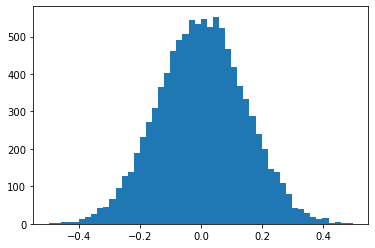

In [241]:
plt.hist(sas.null_distribution, bins=50)

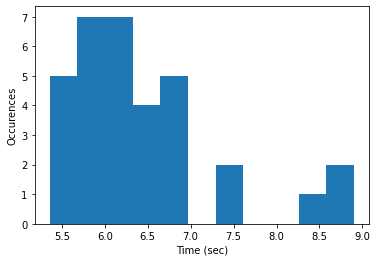

In [257]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
plt.hist(mbrt_im1, bins=11)
plt.xlabel('Time (sec)')
plt.ylabel('Occurences')
plt.savefig('hist.pdf')

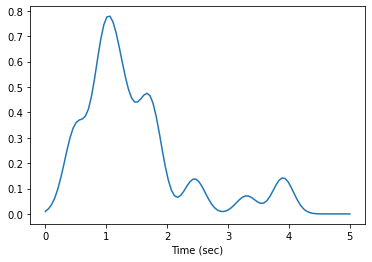

In [269]:
from sklearn.neighbors import KernelDensity
X = mbrt_im1 - 5
X = X[~np.isnan(X)]
kde = KernelDensity(kernel='gaussian', bandwidth=0.17).fit(X[:, None])
scores_span = np.linspace(0, 5, 100)
scores = np.exp(kde.score_samples(scores_span[:, None]))
plt.plot(scores_span, scores)
plt.xlabel('Time (sec)')
# plt.ylabel('')
plt.savefig('hist.pdf')

In [122]:
import networkx as nx
funs = {
    'centrality': nx.betweenness_centrality,
    'clust_coef': nx.clustering,
    'strength': nx.degree
}
res_dict = {}

func_corr = lambda x: stats.permutation_test(x, lambda *o: stats.pearsonr(*o)[0], permutation_type='pairings', n_resamples=2000)
mask = ~np.isnan(mbrt_im1)

for fname in tqdm(fnames_im1):
    res_dict[fname] = {}
    sas = loadmat(fname)
    sos = sas['nbs']
    cons = sos['conmatr']
    cons_post = cons[..., :34]
    cons_base = cons[..., 34:]
    cons = [cons_post, cons_base]

    for name, func in funs.items():
        res = []
        for cond in range(2):
            res.append([])
            for sub in range(34):
                G = nx.from_numpy_array(cons[cond][..., sub])
                temp = dict(func(G, weight='weight')).values()
                res[-1].append(list(temp))
        res = np.array(res)
        res = res[0] - res[1]
        corr = [func_corr([mbrt_im1[mask], i[mask]]) for i in res.T]
        corr = np.array([(i.statistic, i.pvalue) for i in corr])
        res_dict[fname][name] = corr
    res = []
    for cond in range(2):
        res.append([])
        for sub in range(34):
            G = nx.from_numpy_array(cons[cond][..., sub])
            res[-1].append(nx.average_clustering(G, weight='weight'))
    res = np.array(res)
    res = res[0] - res[1]
    temp = func_corr([mbrt_im1[mask], np.array(res)[mask]])
    res_dict[fname]['global_coef'] = (temp.statistic, temp.pvalue)

 40%|████      | 2/5 [12:53<19:19, 386.53s/it]/Users/nikitasmirnov/miniconda3/envs/NCT/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 5/5 [32:30<00:00, 390.06s/it]


In [136]:
sas = loadmat(fnames_im1[2])
sos = sas['nbs']
cons = sos['conmatr']
cons_post = cons[..., :34]
cons_base = cons[..., 34:]
cons = [cons_post, cons_base]
res = []
for cond in range(2):
    res.append([])
    for sub in range(34):
        G = nx.from_numpy_array(cons[cond][..., sub])
        temp = dict(nx.betweenness_centrality(G, weight='weight')).values()
        res[-1].append(list(temp))
res = np.array(res)
# res = res[0] - res[1]

In [130]:
res = np.array(res)
res = res[0] - res[1]

In [138]:
res[0, :, 55]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [125]:
dfs = []
mapper = {
    'NBS_Results_foi=10_14Hz_Cond7_greater_Cond1_NBS=5000_0_01_t_thresh=4.mat': '3. 10-14Hz',
    'NBS_Results_foi=12_14Hz_Cond7_greater_Cond1_NBS=5000_0_01_t_thresh=4.mat': '4. 12-14Hz',
    'NBS_Results_foi=14_30Hz_Cond7_greater_Cond1_NBS=5000_0_01_t_thresh=4.mat': '5. 14-30Hz',
    'NBS_Results_foi=4_8Hz_Cond6_greater_Cond1_NBS=5000_0_01_t_thresh=4.mat': '1. 4-8Hz',
    'NBS_Results_foi=8_12Hz_Cond7_greater_Cond1_NBS=5000_0_01_t_thresh=4.mat': '2. 8-12Hz'
}

all_dfs = []
metrics = ['centrality', 'clust_coef', 'strength']
for metric in metrics:
    dfs = []
    for fname in fnames_im1:
        if basename(fname) not in mapper.keys():
            continue
        label = mapper[basename(fname)]
        index = pd.MultiIndex.from_product([[label], sos['NBS']['node_label'].tolist()], names=['Band', 'Zone'])
        df = pd.DataFrame(res_dict[fname][metric], columns=['R', 'p-value'], index=index)
        dfs.append(df)
    df = pd.concat(dfs).query('`p-value` <= 0.05').sort_index()
    all_dfs.append(df)

with pd.ExcelWriter('fnc_measures_all-bands_corr_no-correction.xlsx') as writer:
    for temp_df, metric in zip(all_dfs, metrics):
        try:
            temp_df.to_excel(writer, sheet_name=metric)
        except IndexError:
            pass
    dfs = []
    for fname in fnames_im1:
        if basename(fname) not in mapper.keys():
            continue
        label = mapper[basename(fname)]
        index = pd.MultiIndex.from_product([[label]], names=['Band'])
        df = pd.DataFrame([res_dict[fname]['global_coef']], columns=['R', 'p-value'], index=index)
        dfs.append(df)
    dfs = pd.concat(dfs)
    dfs.to_excel(writer, sheet_name='clust_global')

In [123]:
index = pd.MultiIndex.from_product([['a', 'b'], [1, 2]], names=['a', '1'])

pd.DataFrame(np.random.normal(size=4), index=index).sort_index(level=0, key=lambda x: print(x))

Index(['a', 'a', 'b', 'b'], dtype='object', name='a')


TypeError: object of type 'NoneType' has no len()

In [66]:
res = []
for i in range(34):
    G = nx.from_numpy_array(cons[..., i])
    res.append(func(G, weight='weight'))
res = np.array(res)


In [69]:
res.shape

AttributeError: 'list' object has no attribute 'shape'

In [67]:
pd.DataFrame.to_excel()

array([{0: 0.8726926010678872, 1: 0.10961098398169337, 2: 0.3572845156369184, 3: 0.32067124332570557, 4: 0.3128146453089245, 5: 0.6639206712433258, 6: 0.45339435545385204, 7: 0.23142639206712434, 8: 0.39305873379099926, 9: 0.8219679633867277, 10: 0.9456903127383677, 11: 0.7707856598016781, 12: 0.9282990083905416, 13: 0.7958810068649886, 14: 0.5048054919908467, 15: 0.868421052631579, 16: 0.9272311212814646, 17: 0.10251716247139589, 18: 0.6763539282990084, 19: 0.3341723874904653, 20: 0.48596491228070177, 21: 0.2601067887109077, 22: 0.22395118230358507, 23: 0.6857360793287567, 24: 0.28565980167810834, 25: 0.16140350877192983, 26: 0.6817696414950419, 27: 0.3137299771167048, 28: 0.8638443935926774, 29: 0.5289855072463768, 30: 0.4793287566742945, 31: 0.2799389778794813, 32: 0.0, 33: 0.0040427154843630814, 34: 0.20983981693363846, 35: 0.13592677345537757, 36: 0.3491228070175439, 37: 0.0, 38: 0.33806254767353167, 39: 0.05819984744469871, 40: 0.4742181540808543, 41: 0.4469870327993898, 42: 0.81

In [97]:
test = func(G, weight='weight')

In [100]:
dict(test).values()

dict_values([0.1540369933992916, -0.50146358593921, -0.3419220956201562, -3.354142123067668, -2.9981007195312235, -3.435325940270046, 1.4640266636774046, -3.7520340460256794, -1.9513743312861083, -3.5078769216365933, 0.4522389486208544, -3.266708060520835, 0.16386455576221015, -4.375092641538561, -2.4094775513334716, -3.59088226808934, -0.012326487391655414, 1.272520597453026, 2.2154417951896943, 1.6907120832390719, -2.175007205634766, -1.859202580674614, -2.925206596841441, -3.664929212292577, -3.961061000973653, -3.561195188176512, -3.4337450893497445, -3.099233381335155, -0.23081227998182297, -1.5739205409357695, -3.034180411094989, -3.3778356436593815, 2.7720994081953325, -0.42526667151635505, 2.606710583280166, 0.28740103496200087, -1.202385787325152, 2.0530295768683193, -1.4905192667860332, 2.0126634278969022, -0.8381611107954607, 0.5299949637668238, 1.3352522795590844, 0.45954886345853707, -1.5666191825290354, -2.2587558047704737, 0.7033304053536881, 1.3265081384991446, -1.21468